In [1]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
import os
import pickle

%matplotlib inline

### read in data

In [2]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# training set - read in filenames and logspace flux values
with open ('../grid_metadata/core78.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cube78.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)   

In [7]:
nancube

array([[-10.572355 , -10.058474 ,  -9.74388  , ...,  -5.2017303,
         -5.2274623,  -5.252492 ],
       [ -9.439394 ,  -8.533601 ,  -8.219497 , ...,  -4.129886 ,
         -4.1627316,  -4.193857 ],
       [-15.808239 , -13.968404 , -13.552333 , ...,  -5.837796 ,
         -5.870259 ,  -5.901436 ],
       ...,
       [-13.632972 , -13.03341  , -12.611651 , ...,  -3.668877 ,
         -3.7018733,  -3.7335577],
       [-11.696029 , -11.378522 , -11.108944 , ...,  -4.4081073,
         -4.441105 ,  -4.472864 ],
       [-12.210688 , -11.764603 , -11.48287  , ...,  -4.5828166,
         -4.616759 ,  -4.6493354]], dtype=float32)

### implement PCA on core sample of 78 models from grid

In [3]:
# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [8]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

In [9]:
t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

done in 0.081s


In [10]:
eigenseds=np.array(pca.components_)
eigenseds.shape

(40, 500)

In [11]:
def show_SED(fluxvals):
    fig,ax=plt.subplots(1,figsize=(12,9))
    ax.plot(np.log10(xvals), fluxvals)
    #ax.set_ylim(-6,5)
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

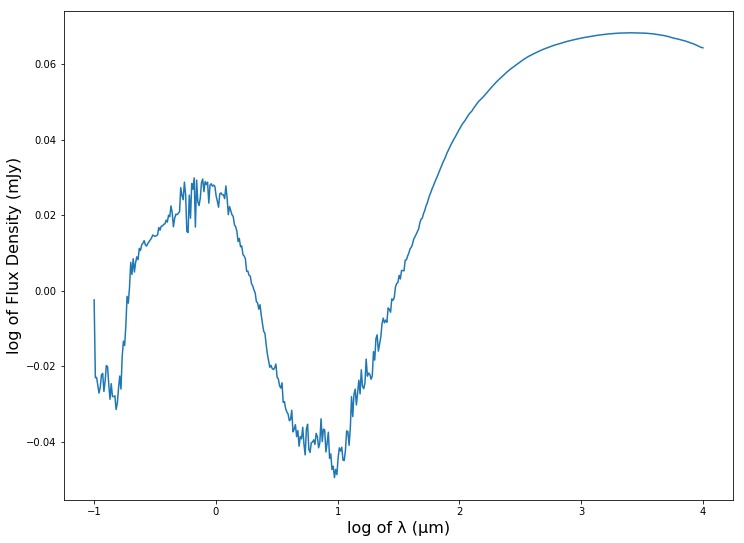

In [15]:
show_SED(eigenseds[2])

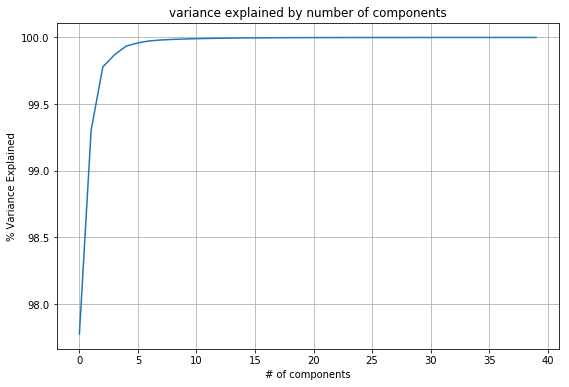

In [16]:
fig,ax=plt.subplots(1,figsize=(9,6))
plt.ylabel('% Variance Explained')
plt.xlabel('# of components')
plt.title('variance explained by number of components')
plt.style.context('seaborn-whitegrid')
ax.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid()
plt.show()

### read in slice data

In [17]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)

In [18]:
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

In [19]:
# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

### fit slices

In [20]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])

In [21]:
np.array(fitdata).shape

(15, 0)

In [22]:
fitdata

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

In [23]:
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)

In [24]:
fitdata[0][0]

[3000.0,
 -34.63702,
 -2.563048,
 4.072273,
 7.8249965,
 -4.796682,
 0.62728834,
 -0.6329272,
 -1.5941757,
 1.4989474,
 -0.84766304]

### plot coefficient values against parameter values

In [25]:
def plotpcwpar(param,coeffindex):
    fig,ax=plt.subplots(1,figsize=(12,9))
    pvals=[]
    cvals=[]
    for i in range(11):
        pvals.append(fitdata[param][i][0])
        cvals.append(fitdata[param][i][coeffindex+1])
    ax.scatter(pvals,cvals)
    plt.title("principal component #"+str(coeffindex)+" weight versus "+param_names[param],fontsize=16)
    plt.ylabel("w"+str(coeffindex),fontsize=16)
    plt.xlabel(param_names[param],fontsize=16)
    plt.show()    

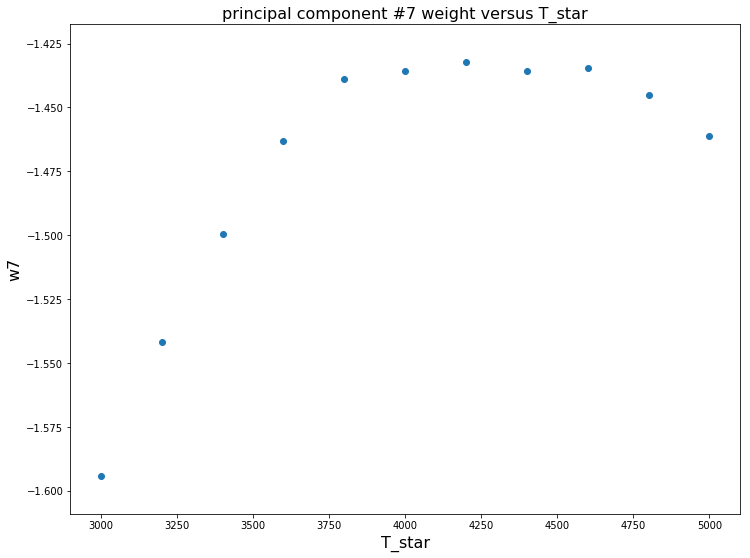

In [26]:
plotpcwpar(0,7)

In [27]:
def plotpcwpar_all(param):
    #pdf = PdfPages("../visualization/pcwpar/"+param_names[param]+"_pcwpar.pdf")
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(8,12))
    
    for coeffindex in range(10):
        pvals=[]
        cvals=[]
        for i in range(11):
            pvals.append(fitdata[param][i][0])
            cvals.append(fitdata[param][i][coeffindex+1])
            
        ax[coeffindex//2][coeffindex%2].scatter(pvals,cvals)
        ax[coeffindex//2][coeffindex%2].set_xlabel(param_names[param])
        ax[coeffindex//2][coeffindex%2].set_ylabel("w"+str(coeffindex))
    
    plt.subplots_adjust(hspace=0.6)
    plt.subplots_adjust(wspace=0.7)
    plt.show()
    
    # Now save the figure.
    #pdf.savefig(fig)
    plt.clf()

    # Close the pdf.
    #pdf.close()
    print("principal component weight/parameter plots generated for ", param_names[param])

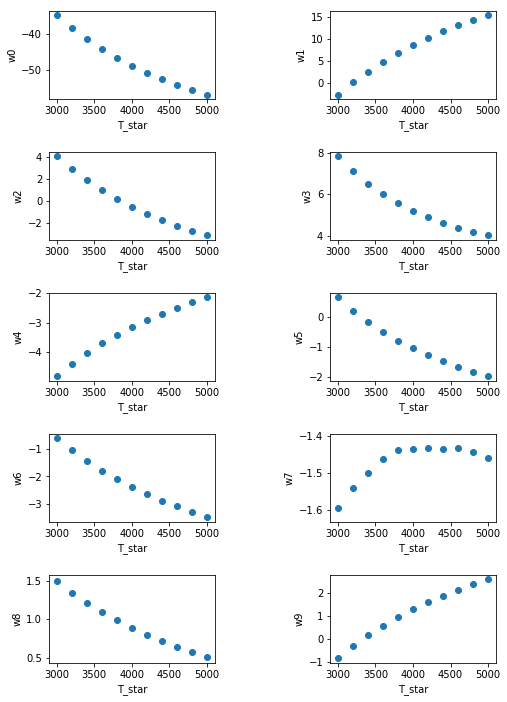

principal component weight/parameter plots generated for  T_star


<Figure size 432x288 with 0 Axes>

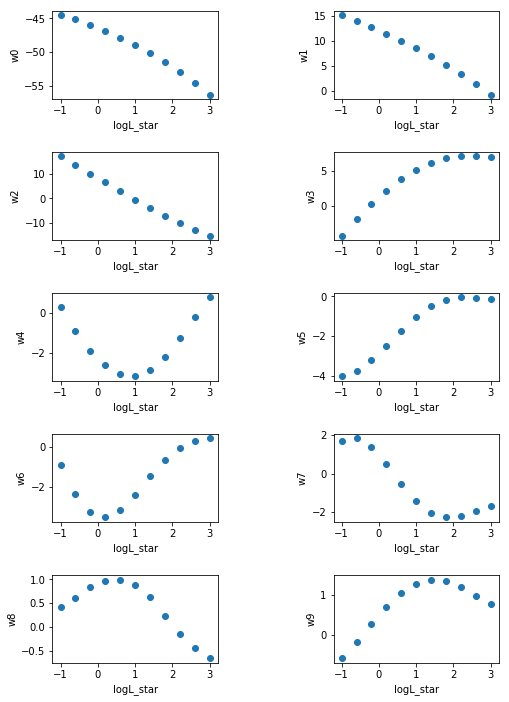

principal component weight/parameter plots generated for  logL_star


<Figure size 432x288 with 0 Axes>

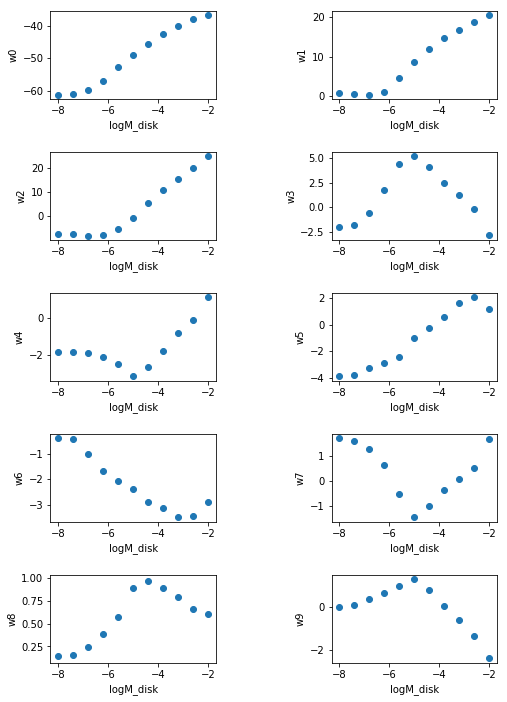

principal component weight/parameter plots generated for  logM_disk


<Figure size 432x288 with 0 Axes>

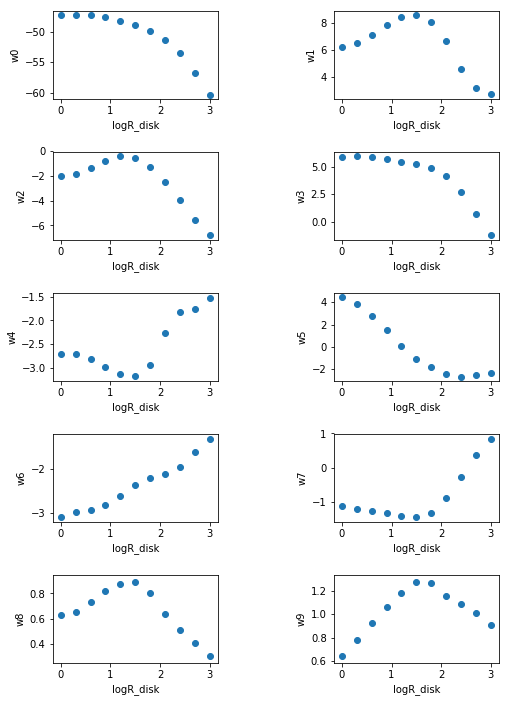

principal component weight/parameter plots generated for  logR_disk


<Figure size 432x288 with 0 Axes>

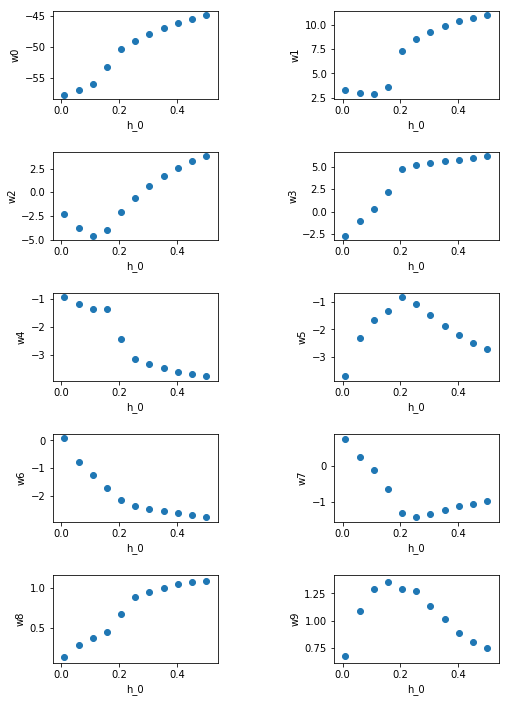

principal component weight/parameter plots generated for  h_0


<Figure size 432x288 with 0 Axes>

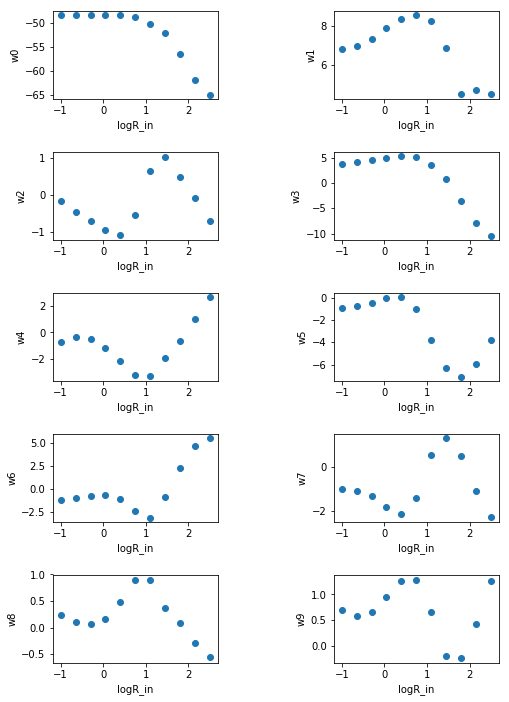

principal component weight/parameter plots generated for  logR_in


<Figure size 432x288 with 0 Axes>

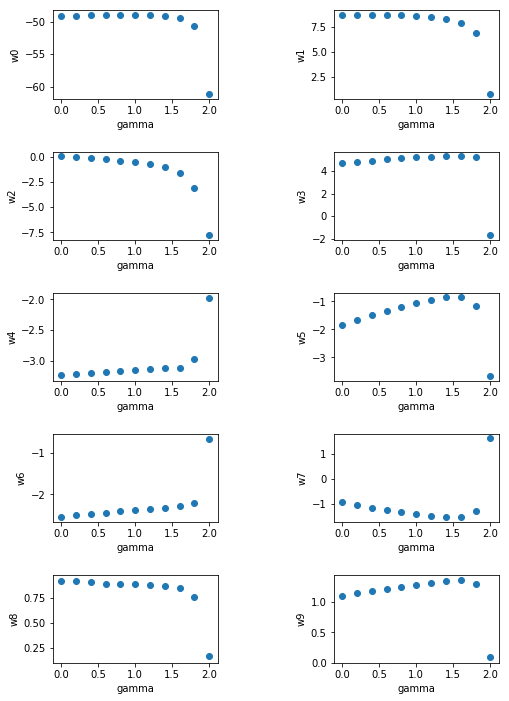

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

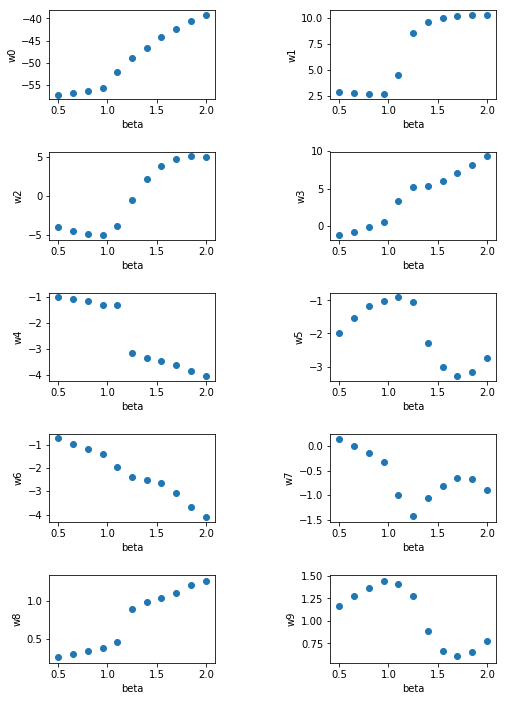

principal component weight/parameter plots generated for  beta


<Figure size 432x288 with 0 Axes>

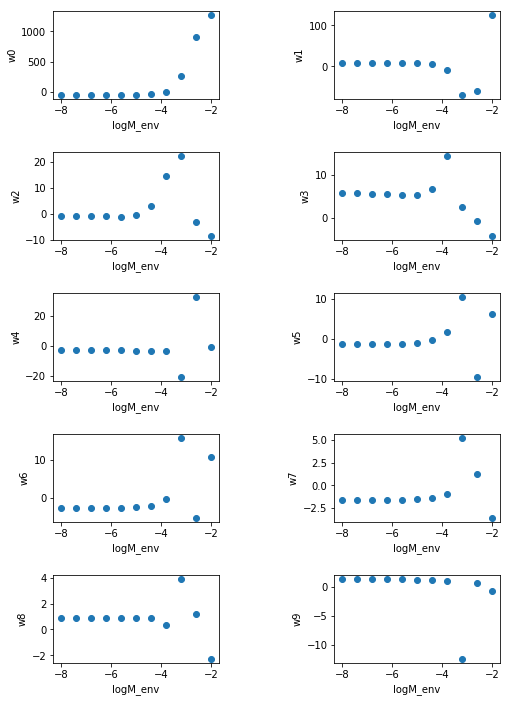

principal component weight/parameter plots generated for  logM_env


<Figure size 432x288 with 0 Axes>

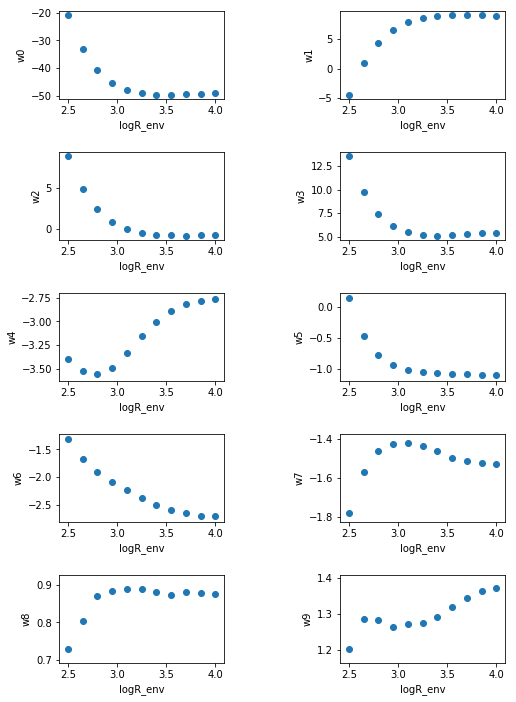

principal component weight/parameter plots generated for  logR_env


<Figure size 432x288 with 0 Axes>

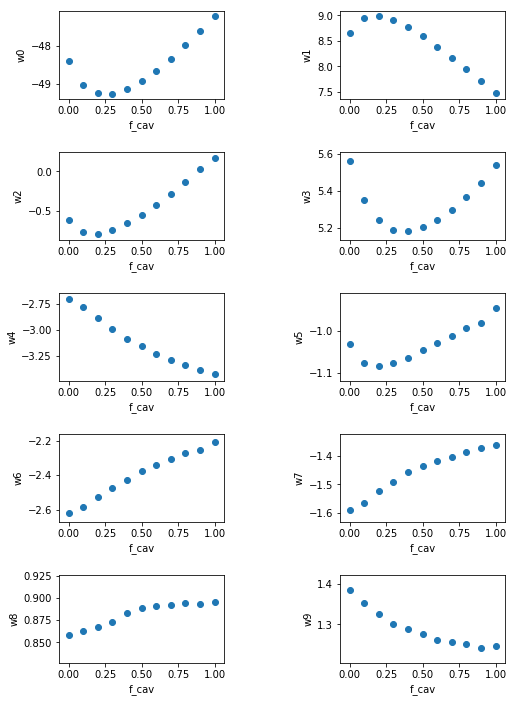

principal component weight/parameter plots generated for  f_cav


<Figure size 432x288 with 0 Axes>

/users/eteng/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


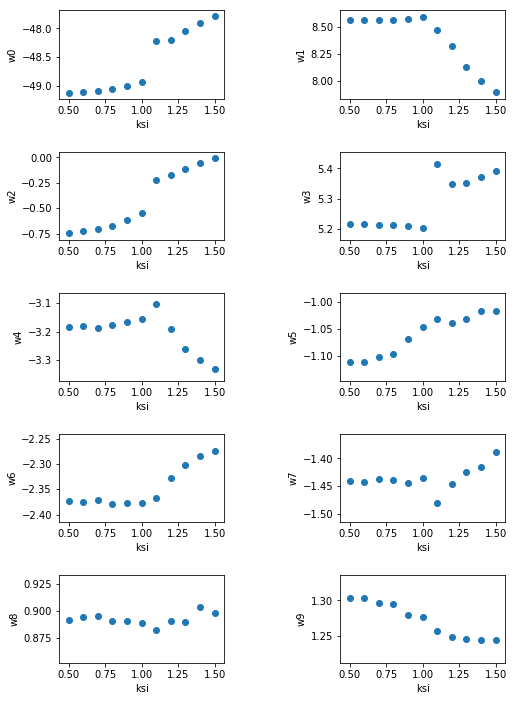

principal component weight/parameter plots generated for  ksi


<Figure size 432x288 with 0 Axes>

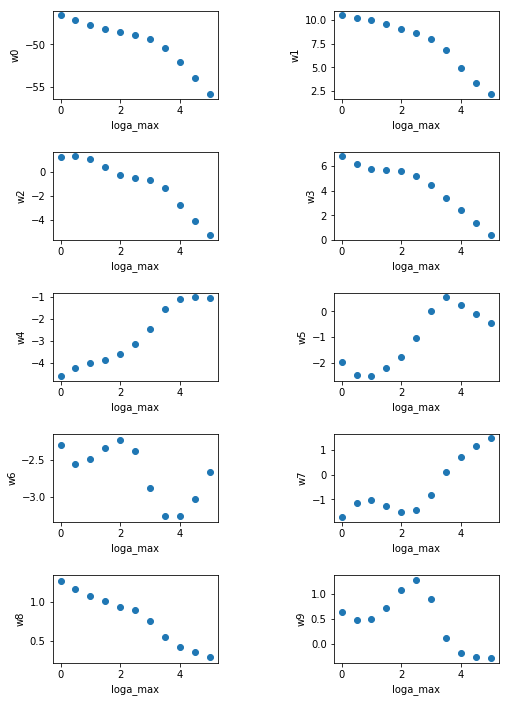

principal component weight/parameter plots generated for  loga_max


<Figure size 432x288 with 0 Axes>

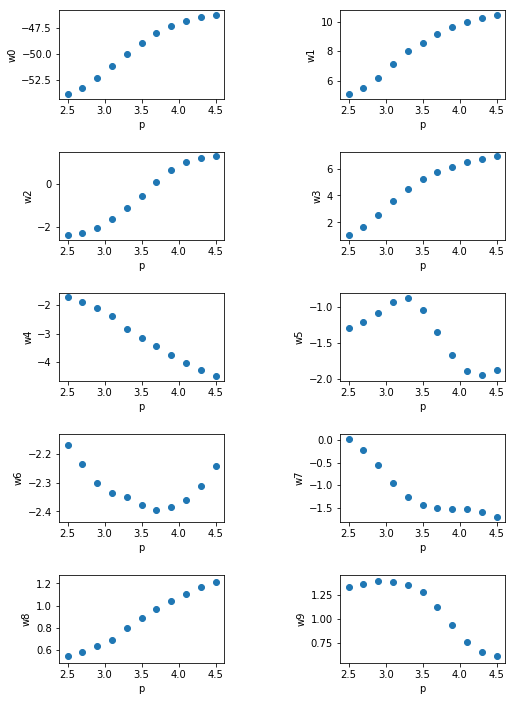

principal component weight/parameter plots generated for  p


<Figure size 432x288 with 0 Axes>

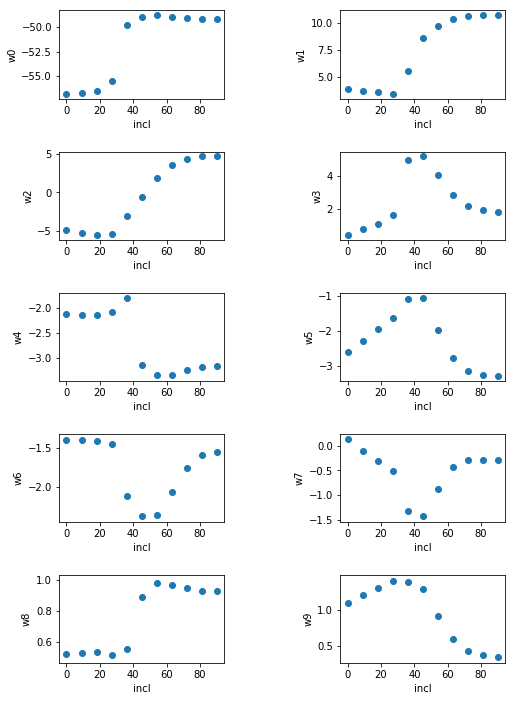

principal component weight/parameter plots generated for  incl


<Figure size 432x288 with 0 Axes>

In [28]:
for i in range(len(param_names)):
    plotpcwpar_all(i)

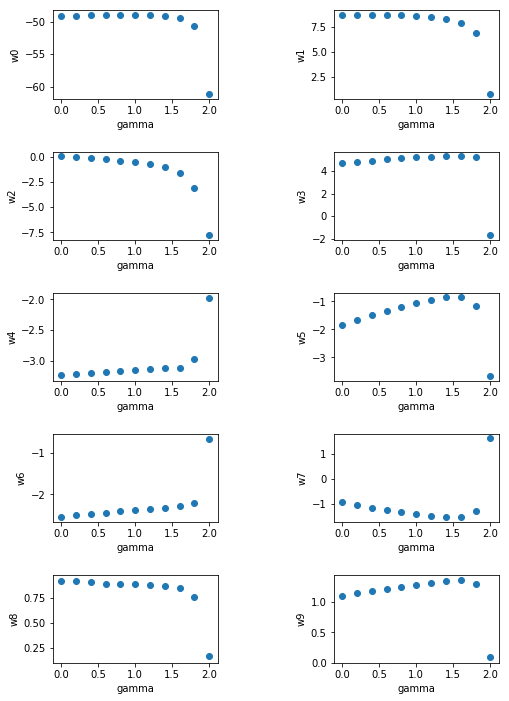

principal component weight/parameter plots generated for  gamma


<Figure size 432x288 with 0 Axes>

In [30]:
plotpcwpar_all(6)

### visualizing model fitting

In [31]:
def sedcomp(param,model,ncomp=10, nfeat=500):
    fig,ax=plt.subplots(1,figsize=(12,9))
    coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
    reconst=np.dot(coeffs[0][0:ncomp],eigenseds[0:ncomp,0:nfeat]) \
            +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
    ax.plot(np.log10(xvals)[0:nfeat], reconst, c='b',label="reconstructed SED, ncomp="+str(ncomp))
    ax.plot(np.log10(xvals)[0:nfeat], slicevals[param][model][0:nfeat], c='black',label="pdspy SED")
    plt.legend()
    plt.title("reconstructed SED of "+param_names[param]+"="+str(steps[param][model])+" model against pdspy SED")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

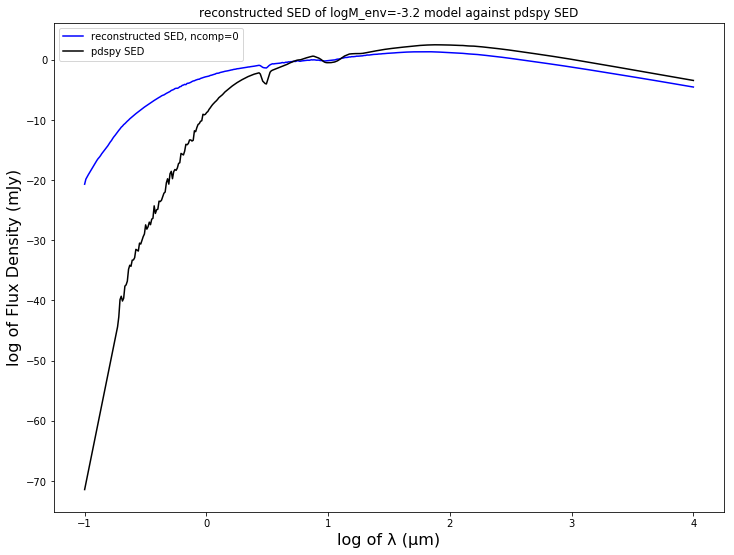

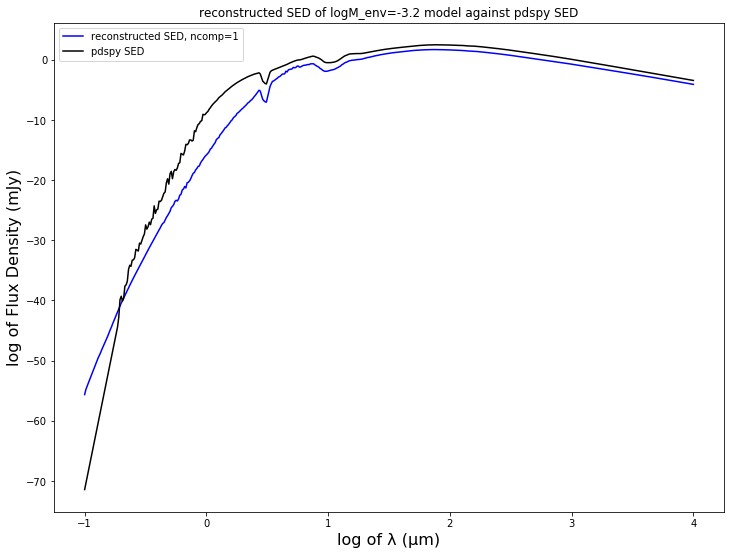

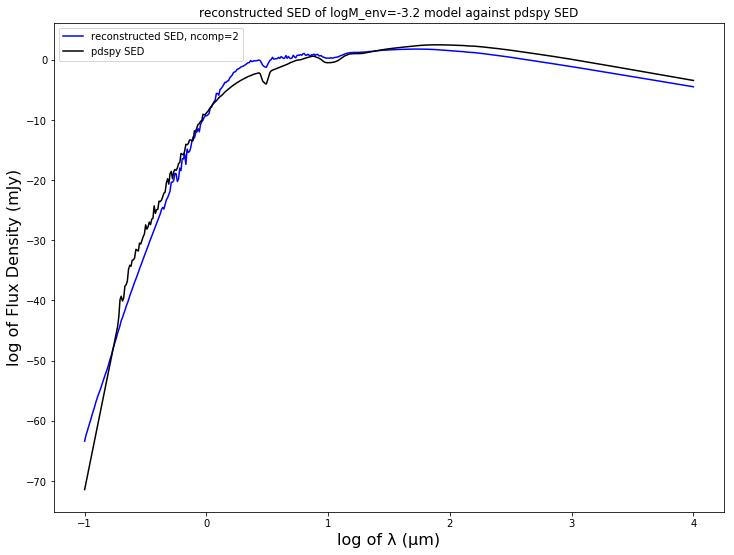

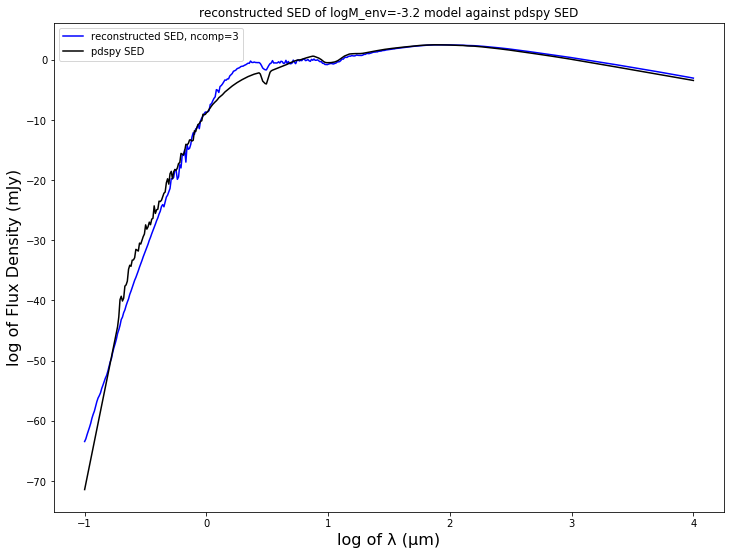

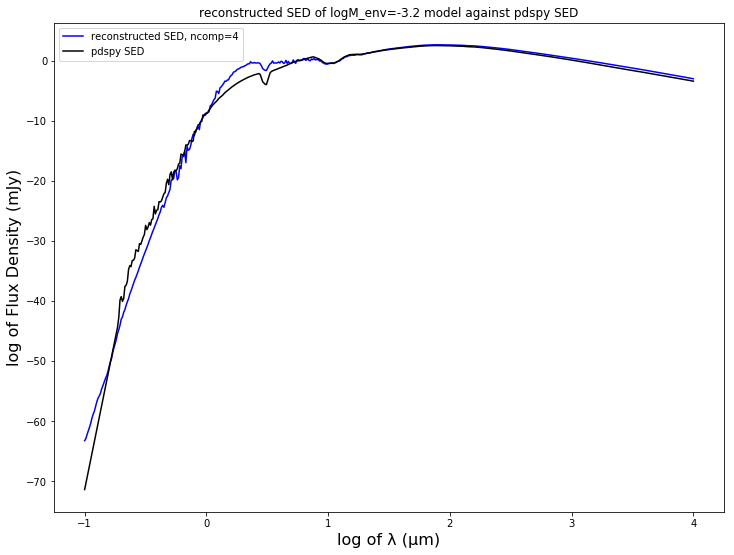

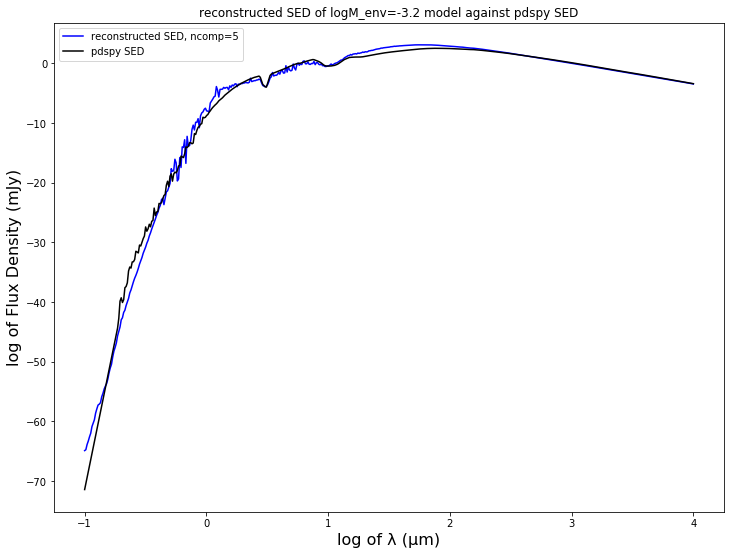

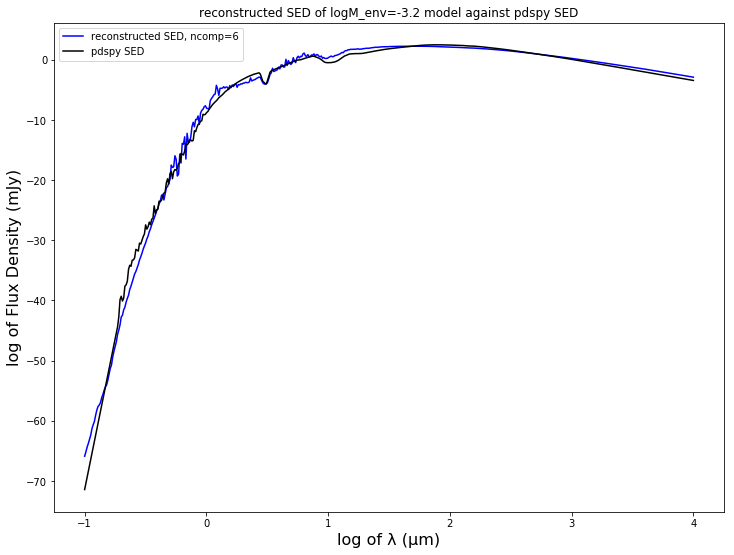

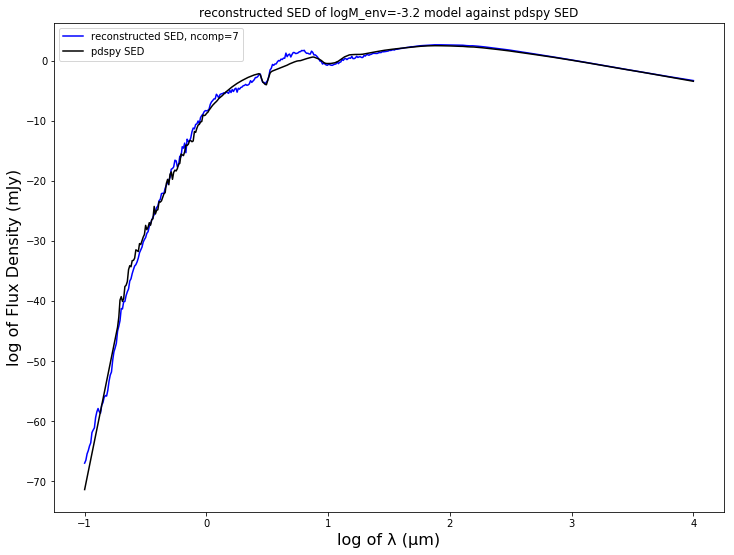

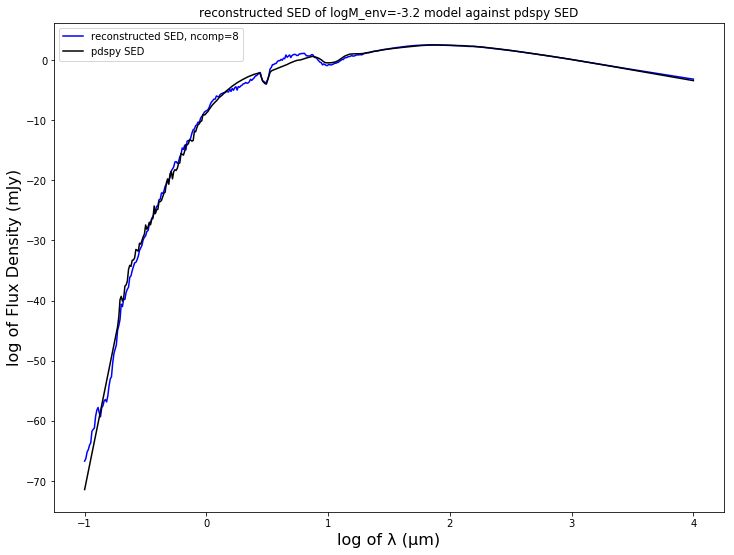

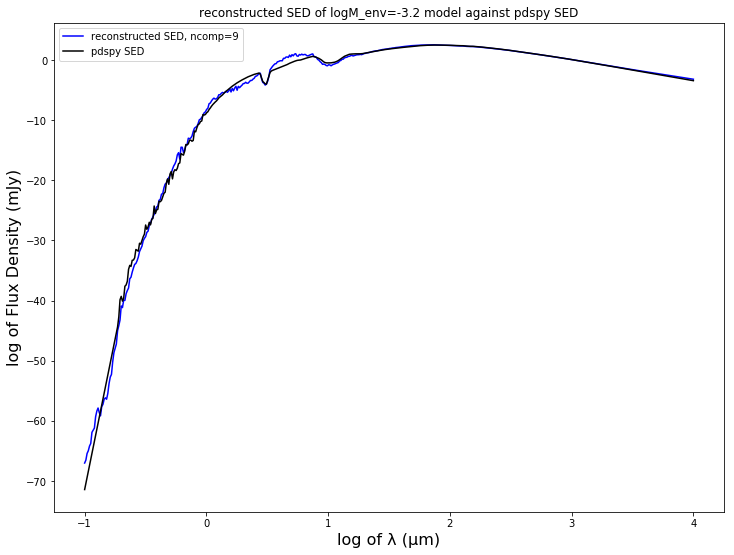

In [32]:
for m in range(10):
    sedcomp(8,8,ncomp=m)

0


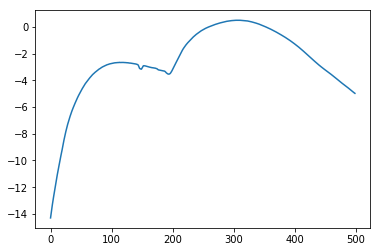

1


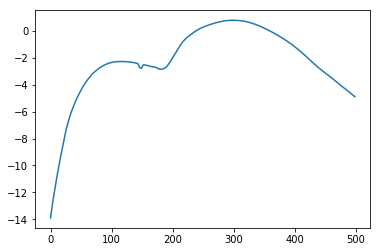

2


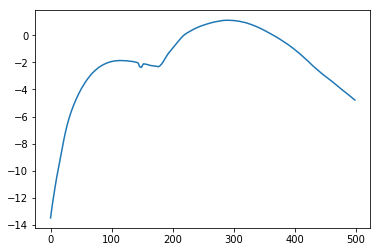

3


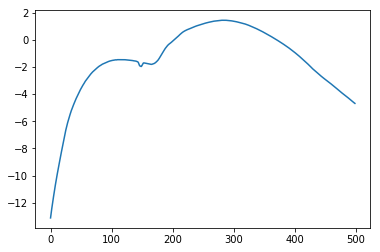

4


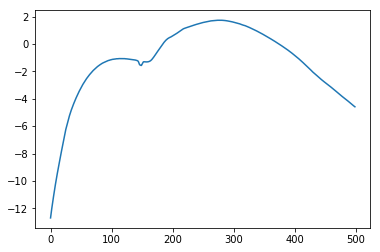

5


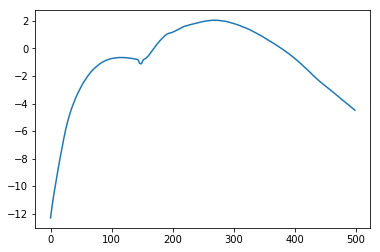

6


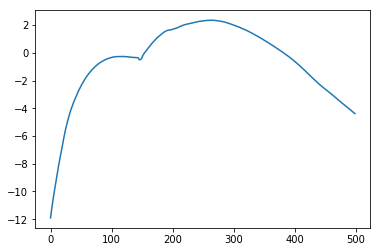

7


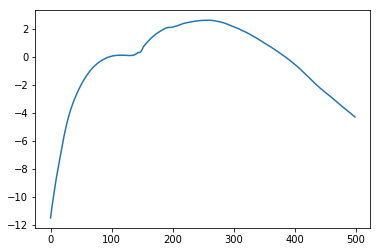

8


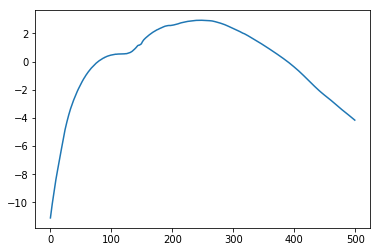

9


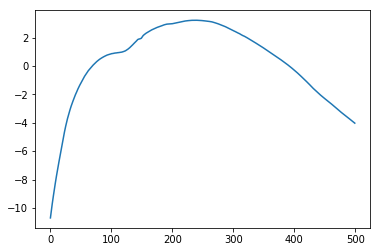

10


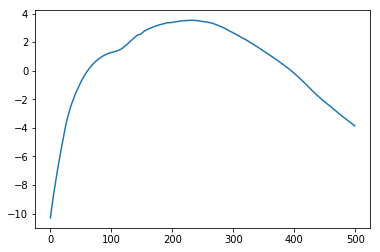

In [44]:
for i in range(11):
    print(i)
    plt.plot(slicevals[1][i])
    plt.show()

In [38]:
def residcomp(param,model,ncomp=10,nfeat=500):
    
    interval=np.linspace(0.1,1.,ncomp)
    colors= plt.cm.viridis(interval)
    
    fig,ax=plt.subplots(1,figsize=(12,9))
    
    for m in range(ncomp):
        coeffs=pca.transform(slice_seds_msub[param][model].reshape(1,-1))
        reconst=np.dot(coeffs[0][0:m],eigenseds[0:m,0:nfeat]) \
                    +pca.mean_[0:nfeat]+np.nanmean(nanslicevals[param][model])    
        resids = reconst-(slicevals[param][model][0:nfeat]) # log flux space residuals
        ax.plot(np.log10(xvals)[0:nfeat],resids, c=colors[m],label="ncomp="+str(m+1)) 
    plt.legend()
    plt.title("log-space residuals of reconst. SEDs of "+param_names[param]+"="+str(steps[param][model])+" model, by number of components")
    plt.ylabel("log of Flux Density (mJy)",fontsize=16)
    plt.xlabel("log of λ (μm)",fontsize=16)
    plt.show()

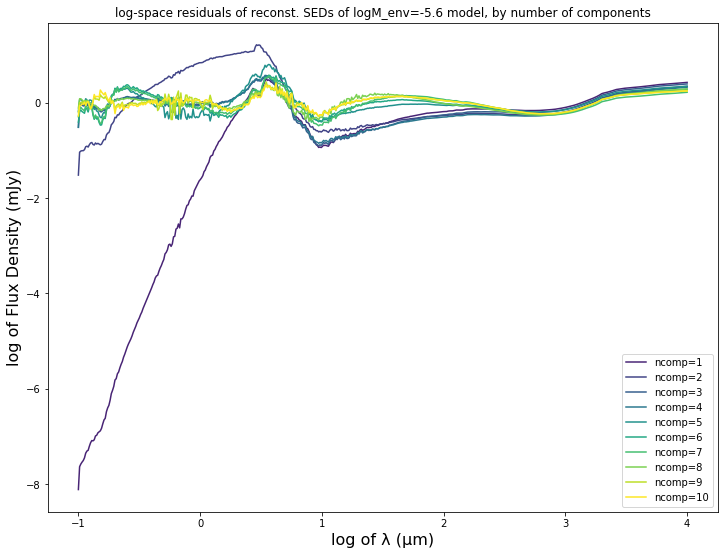

In [40]:
residcomp(8,4)

NameError: name 'np' is not defined